# Inferences experimented on Attention Layers of GPT2 

Notebook includes: Displaying inferences on gpt2 attention blocks

GPT2 Transformer architecture vs everything else (e.g. BERT/Roberta/BART Transformers)
Besides the configured number of layers and training params GPT2's attention block is different in the sense that it utilizes CNN instead of linear layer for the matrix. Hence, the returning matrix sums to 1 satisfying properties of it being a stochastic matrix

#### Loading tokenizer and model

In [1]:
import torch
import torch.nn as nn 
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

/opt/homebrew/Caskroom/miniforge/base/envs/garfield/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
model.config

GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.44.0",
  "use_cache": true,
  "vocab_size": 50257
}

In [7]:
model.state_dict

<bound method Module.state_dict of GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)>

#### Object class for inferencing attn by each dimensions

Given my current task in seeking the differences between default and desired generated texts, I thought it would be efficient to use this as an example while fondling with the attention blocks

In [81]:
positive_prompt = "I love you"
negative_prompt = "I hate you"

In [171]:
import numpy as np 
from typing import Literal 

import seaborn as sns
import matplotlib.pyplot as plt

class Attendance:
    def __init__(self, tokenizer, model):
        self.tokenizer = tokenizer 
        self.model = model 
        self.num_blocks = model.config.n_layer # 12
        if self.model.can_generate():
            self.generate_default_config = self.model.config.task_specific_params.get("text-generation", None)

    def run(self, inputs: str):
        tokens = self.tokenizer(inputs, add_special_tokens=True, return_attention_mask=True, return_tensors="pt")
        with torch.no_grad():
            output = self.model(**tokens, output_attentions=True)
        attn = torch.stack(output.attentions)  # [num_attention_layers, batch_index, num_attention_heads, num_tokens, num_tokens]
        return attn, tokens["input_ids"].squeeze(0)

    def processAttention(self, inputs: str, view_by: Literal["block", "layer"] = "block", block: int = -1, layer: int = -1):
        attn, tokens = self.run(inputs)
        word_tokens = self.tokenizer.convert_ids_to_tokens(tokens, skip_special_tokens=True)
        word_tokens = [i.lstrip("Ġ") for i in word_tokens]
        
        if view_by == "block":
            attention = attn[block] # [1, 12, 3, 3] ~ [batch_index, num_heads, num_tokens, num_tokens]
            attention = attention.squeeze(0) # [12, 3, 3]
            subtitle = """Block {attn_index}""" 
        elif view_by == "layer":
            attention = attn[:, :, layer, :, :] # [12, 1, 3, 3] ~ [num_blocks, batch_index, num_tokens, num_tokens]
            attention = attention.squeeze(1) # [12, 3, 3]
            subtitle = """Layer {attn_index}""" 
        else: 
            raise ValueError("Invalid viewing option entered. Try again ☹️")

        assert attention[0].size(1) == attention.size(-1) and attention.size(0) == self.num_blocks, f"Invalid shape for attention reshaped by layer: {attention.shape}\nAttention:\n{attention}"

        attention_matrix = attention.cpu().numpy()
        return word_tokens, attention_matrix, subtitle 
    
    def _visual_display(self, word_tokens: list, attention_matrix: np.ndarray, subtitle: str):
        # Set up subplots
        fig, axes = plt.subplots(3, 4, figsize=(20, 15))
        axes = axes.flatten()  # Flatten 2D axes array for easy iteration
        
        for index, matrix in enumerate(attention_matrix):
            ax = axes[index]
            sns.heatmap(
                matrix, 
                annot=True,
                fmt=".4f", 
                xticklabels=word_tokens,
                yticklabels=word_tokens,
                cmap="magma",
                ax=ax
            )
            ax.set_title(subtitle.format(attn_index=index+1))
            ax.tick_params(axis='x', rotation=90)
            ax.tick_params(axis='y', rotation=0)
        plt.tight_layout()
        plt.show()
        
    def display(self, inputs: str, view_by: Literal["block", "layer"] = "block", block: int = -1, layer: int = -1):
        word_tokens, attention_matrix, subtitle = self.processAttention(inputs, view_by, block, layer)
        self._visual_display(word_tokens=word_tokens, attention_matrix=attention_matrix, subtitle=subtitle)
        self.last_cache = {
            'word_tokens': word_tokens, 
            'attention': attention_matrix 
        }
        
    def last_attention(self, start: int, use_last_cache: bool = False, inputs: str = None, end: int = None, **kwargs: dict):
        if use_last_cache is False and inputs is None:
            raise ValueError("Provide 'inputs' or enable 'use_last_cache'.")
        if use_last_cache and not hasattr(self, "last_cache"):
            raise ValueError("'last_cache' not found. Run the model with inputs first.")

        if not use_last_cache:
            self.processAttention(inputs, **kwargs)

        attn = self.last_cache["attention"]
        return np.mean(attn[start:, :, :], axis=0) if not end else np.mean(attn[start:end, :, :], axis=0)
        
# Example usage
tv = Attendance(tokenizer, model)

## Viewing by first dimension or Attention block 

#### Layer: <span style="color:cyan;">12</span> (last layer) 

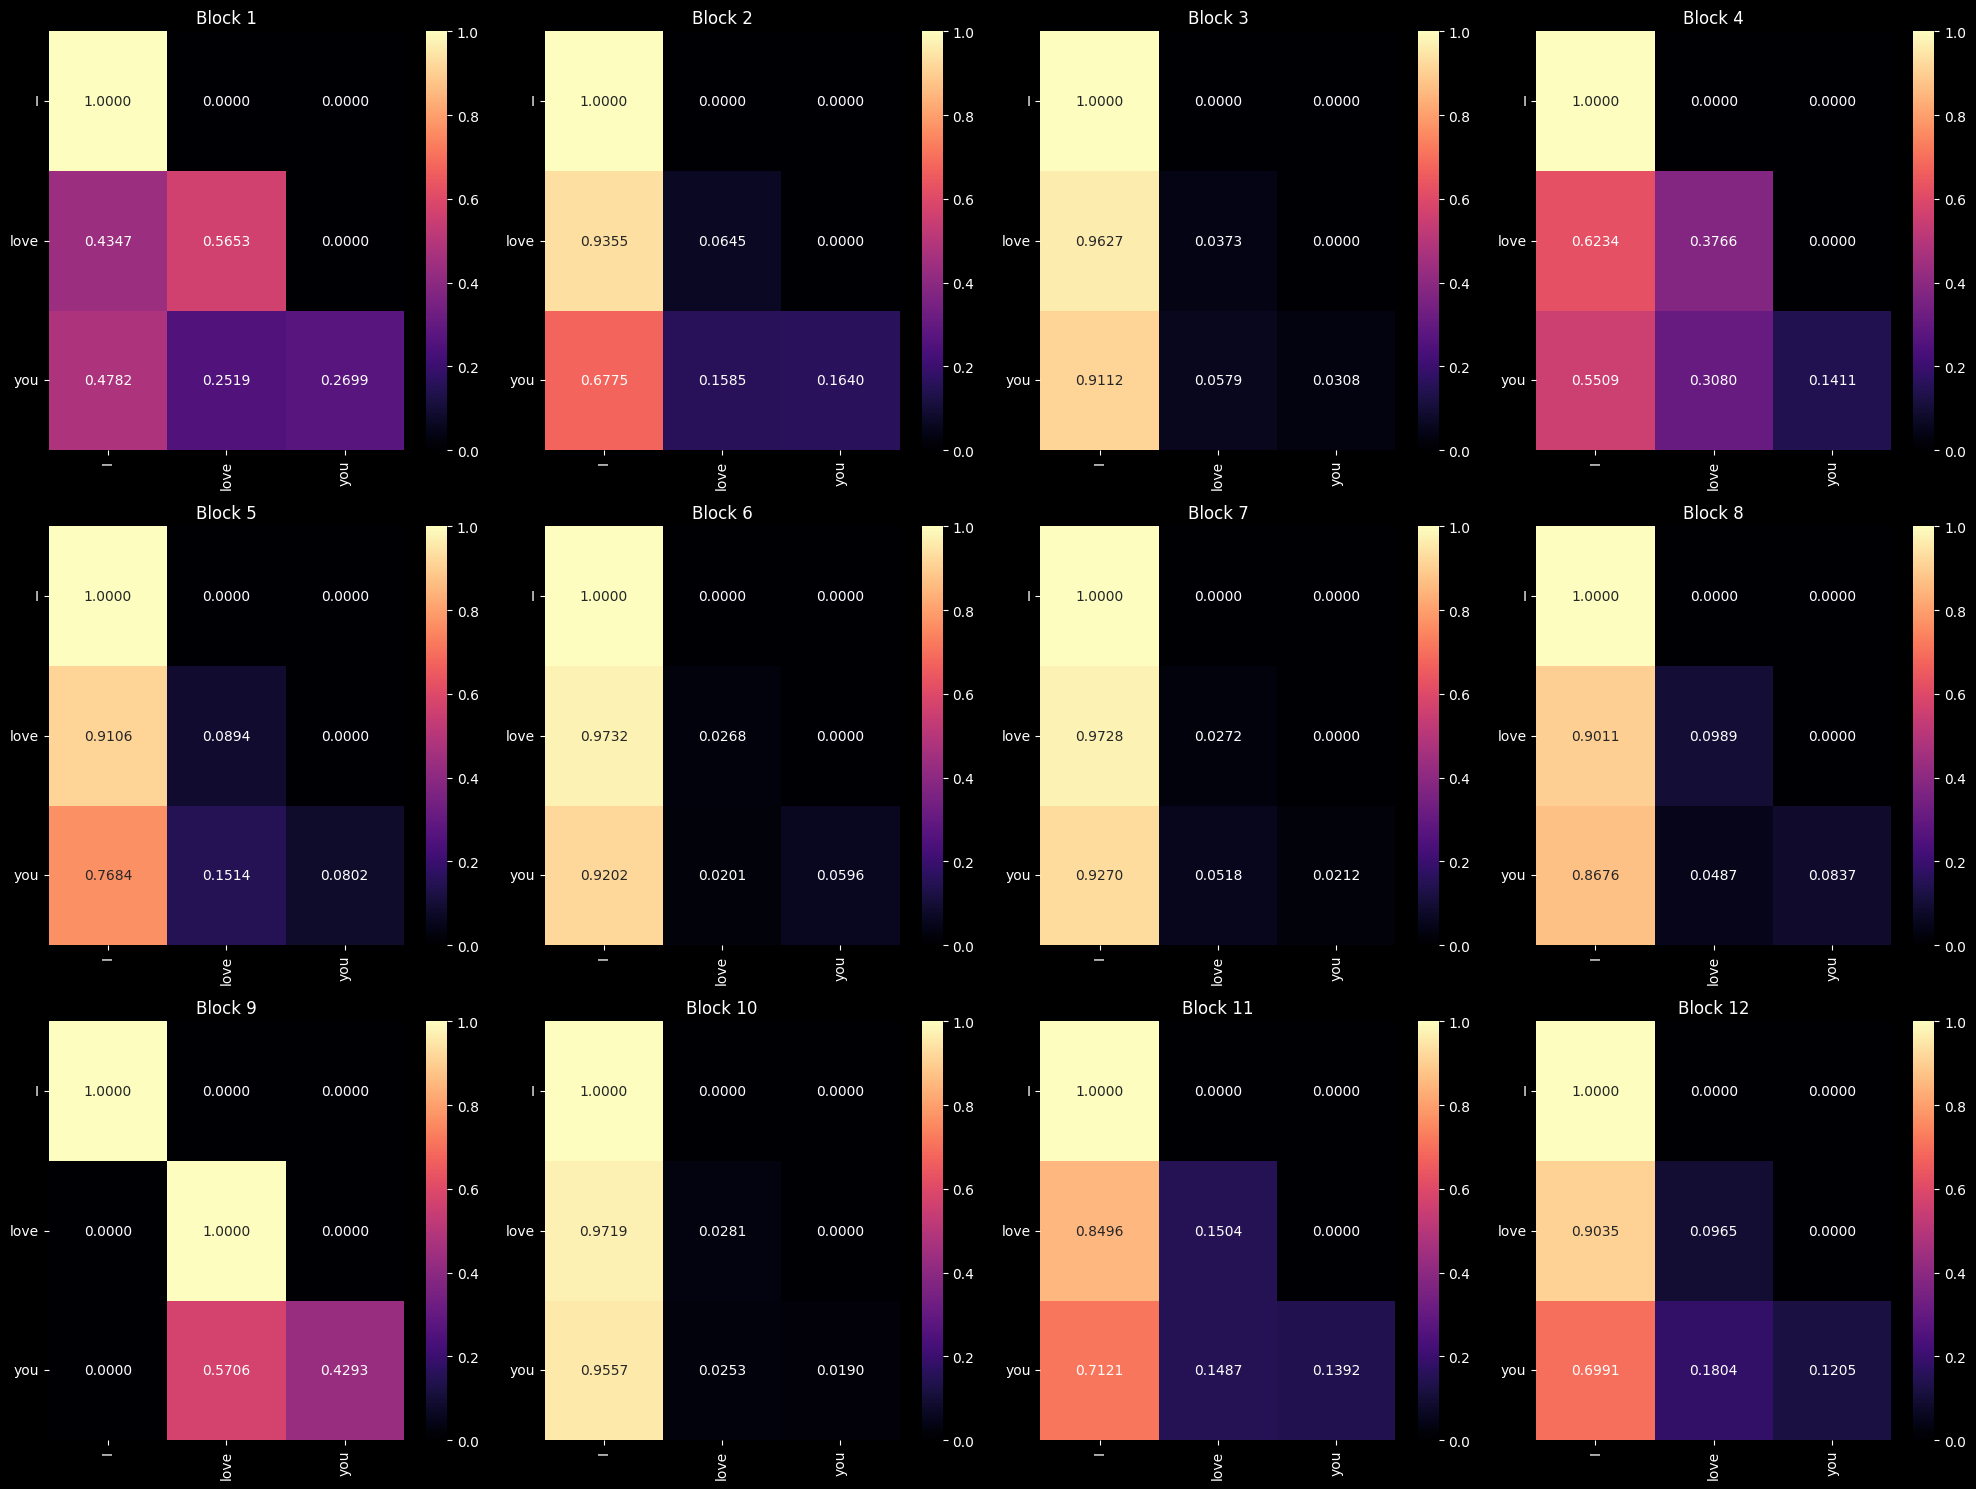

In [118]:
# view positive text "i love you"
tv.display(positive_prompt, view_by="block", layer=-1)

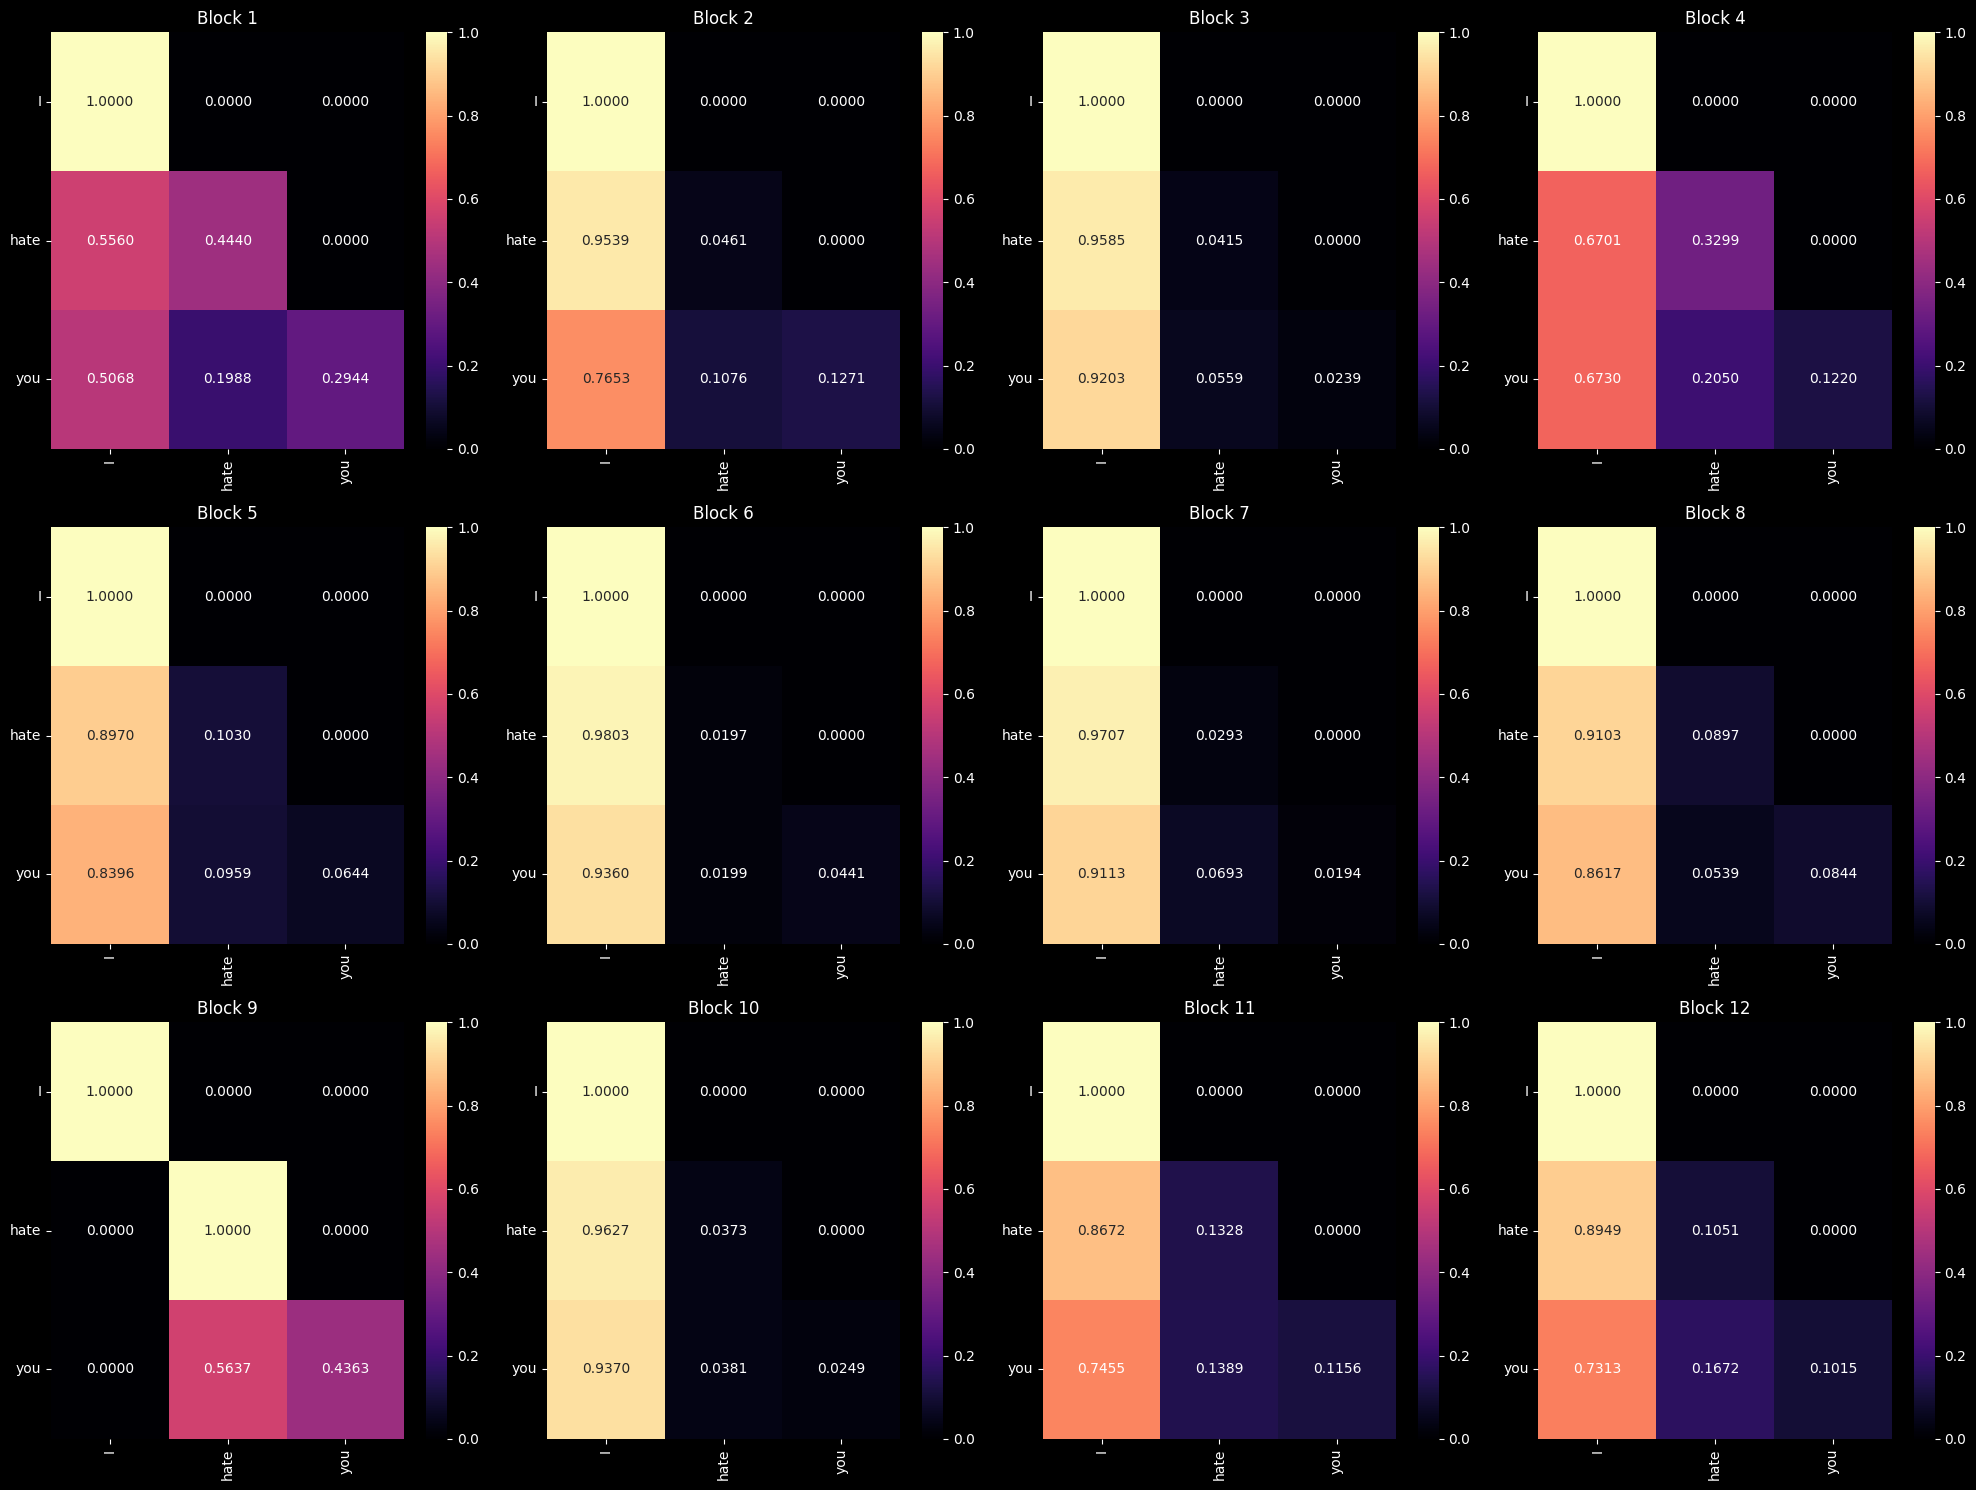

In [119]:
# view negative text "i hate you" 
tv.display(negative_prompt)

#### Layer: <span style="color:cyan;">0</span> (first layer) 

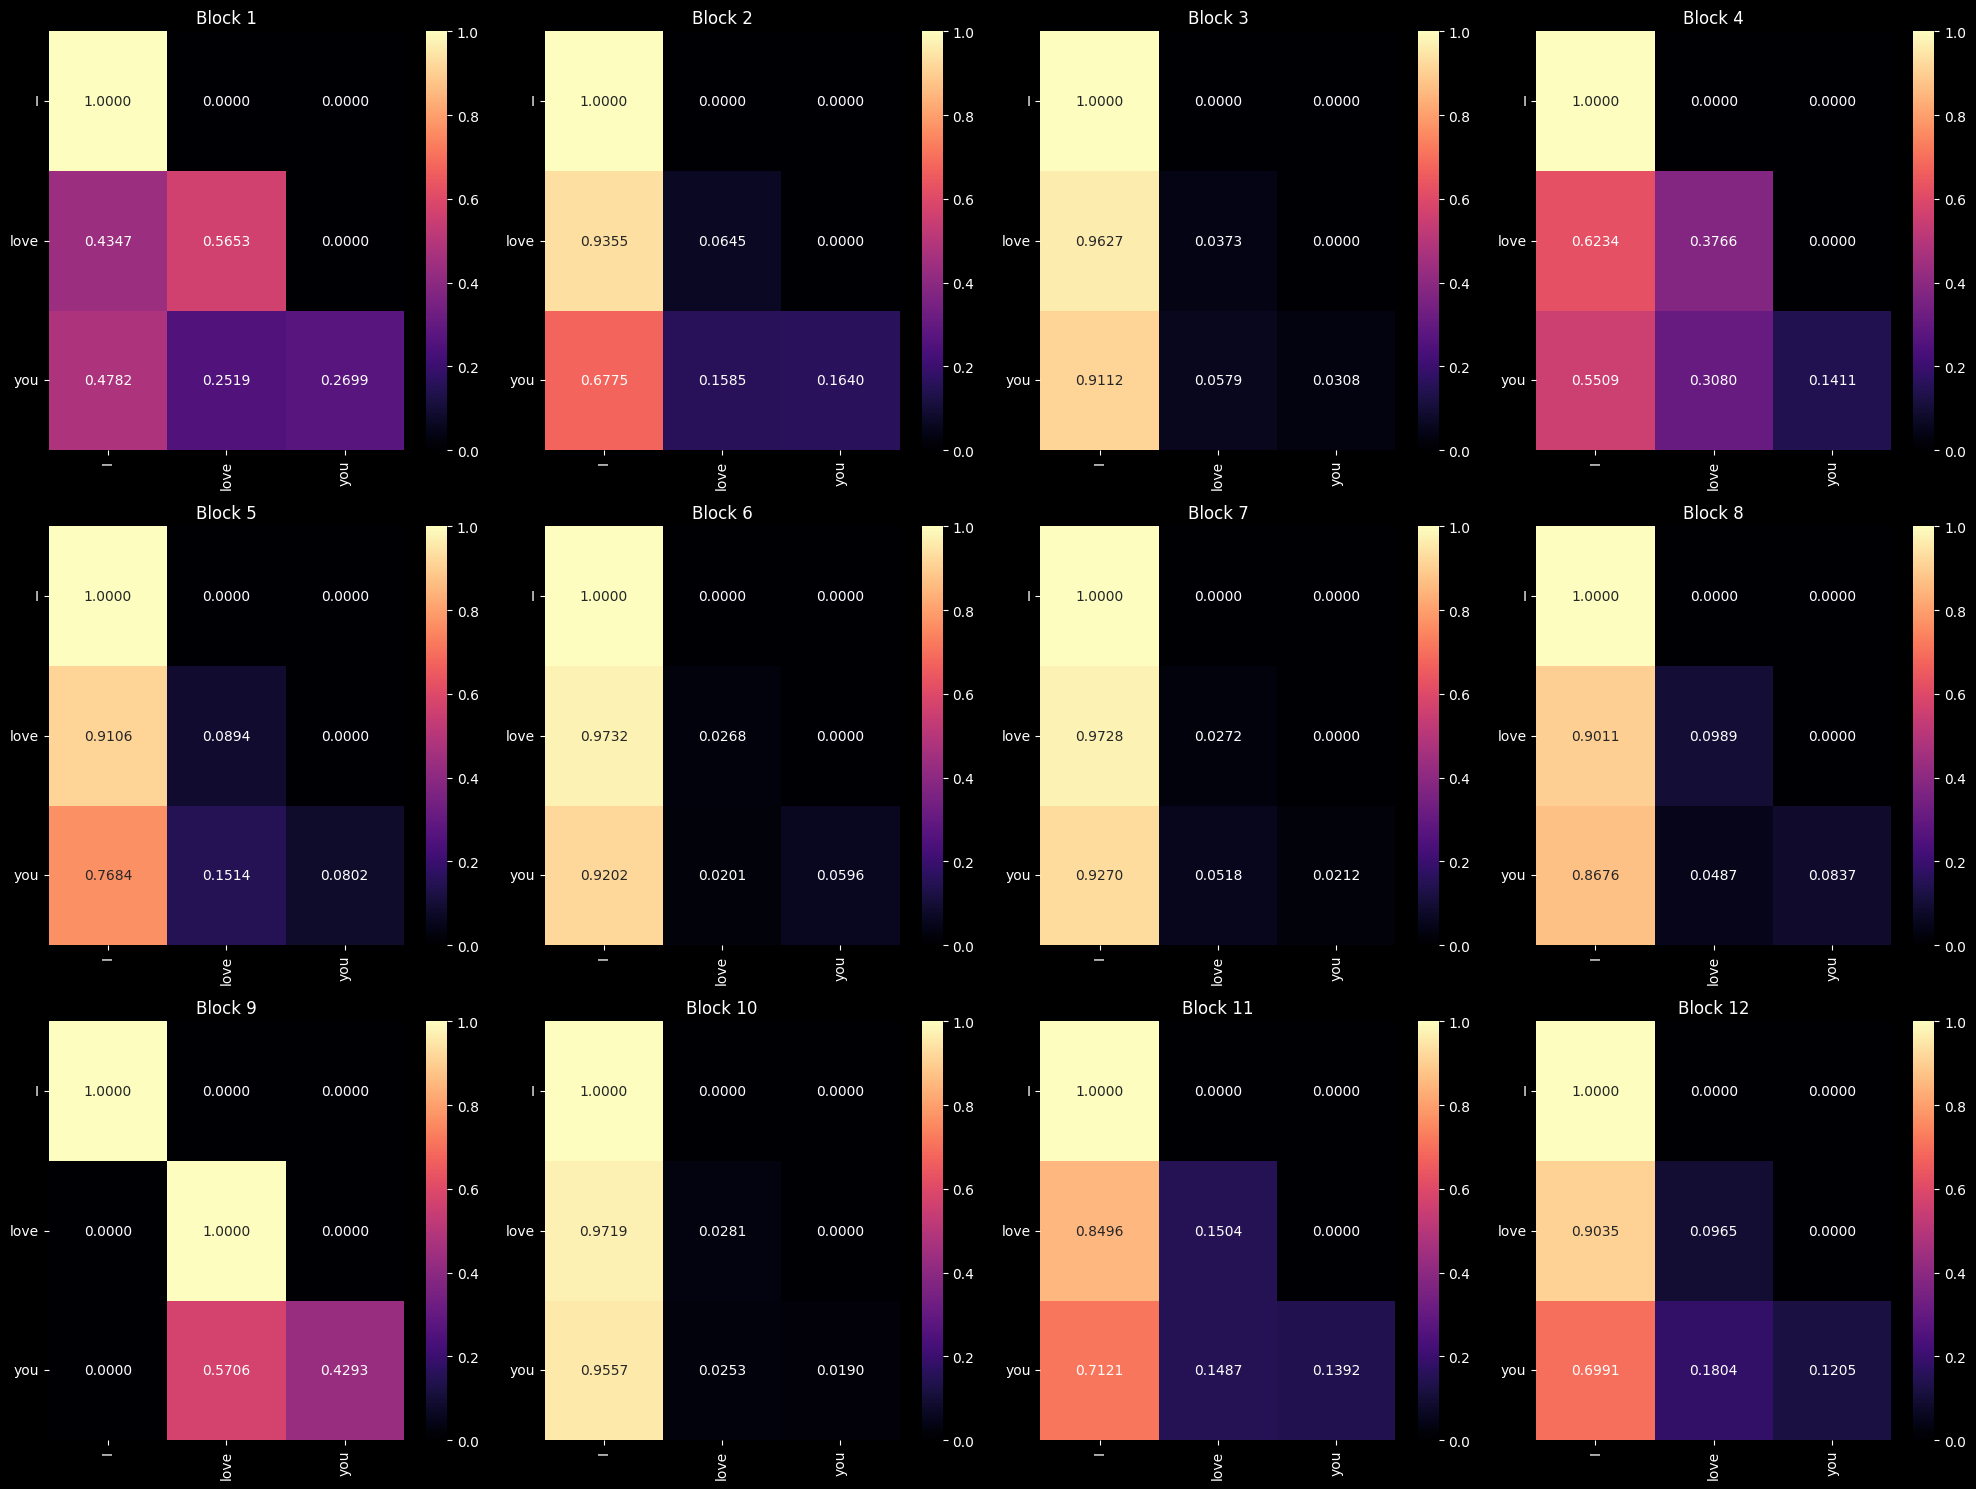

In [169]:
tv.display(positive_prompt, layer=0)

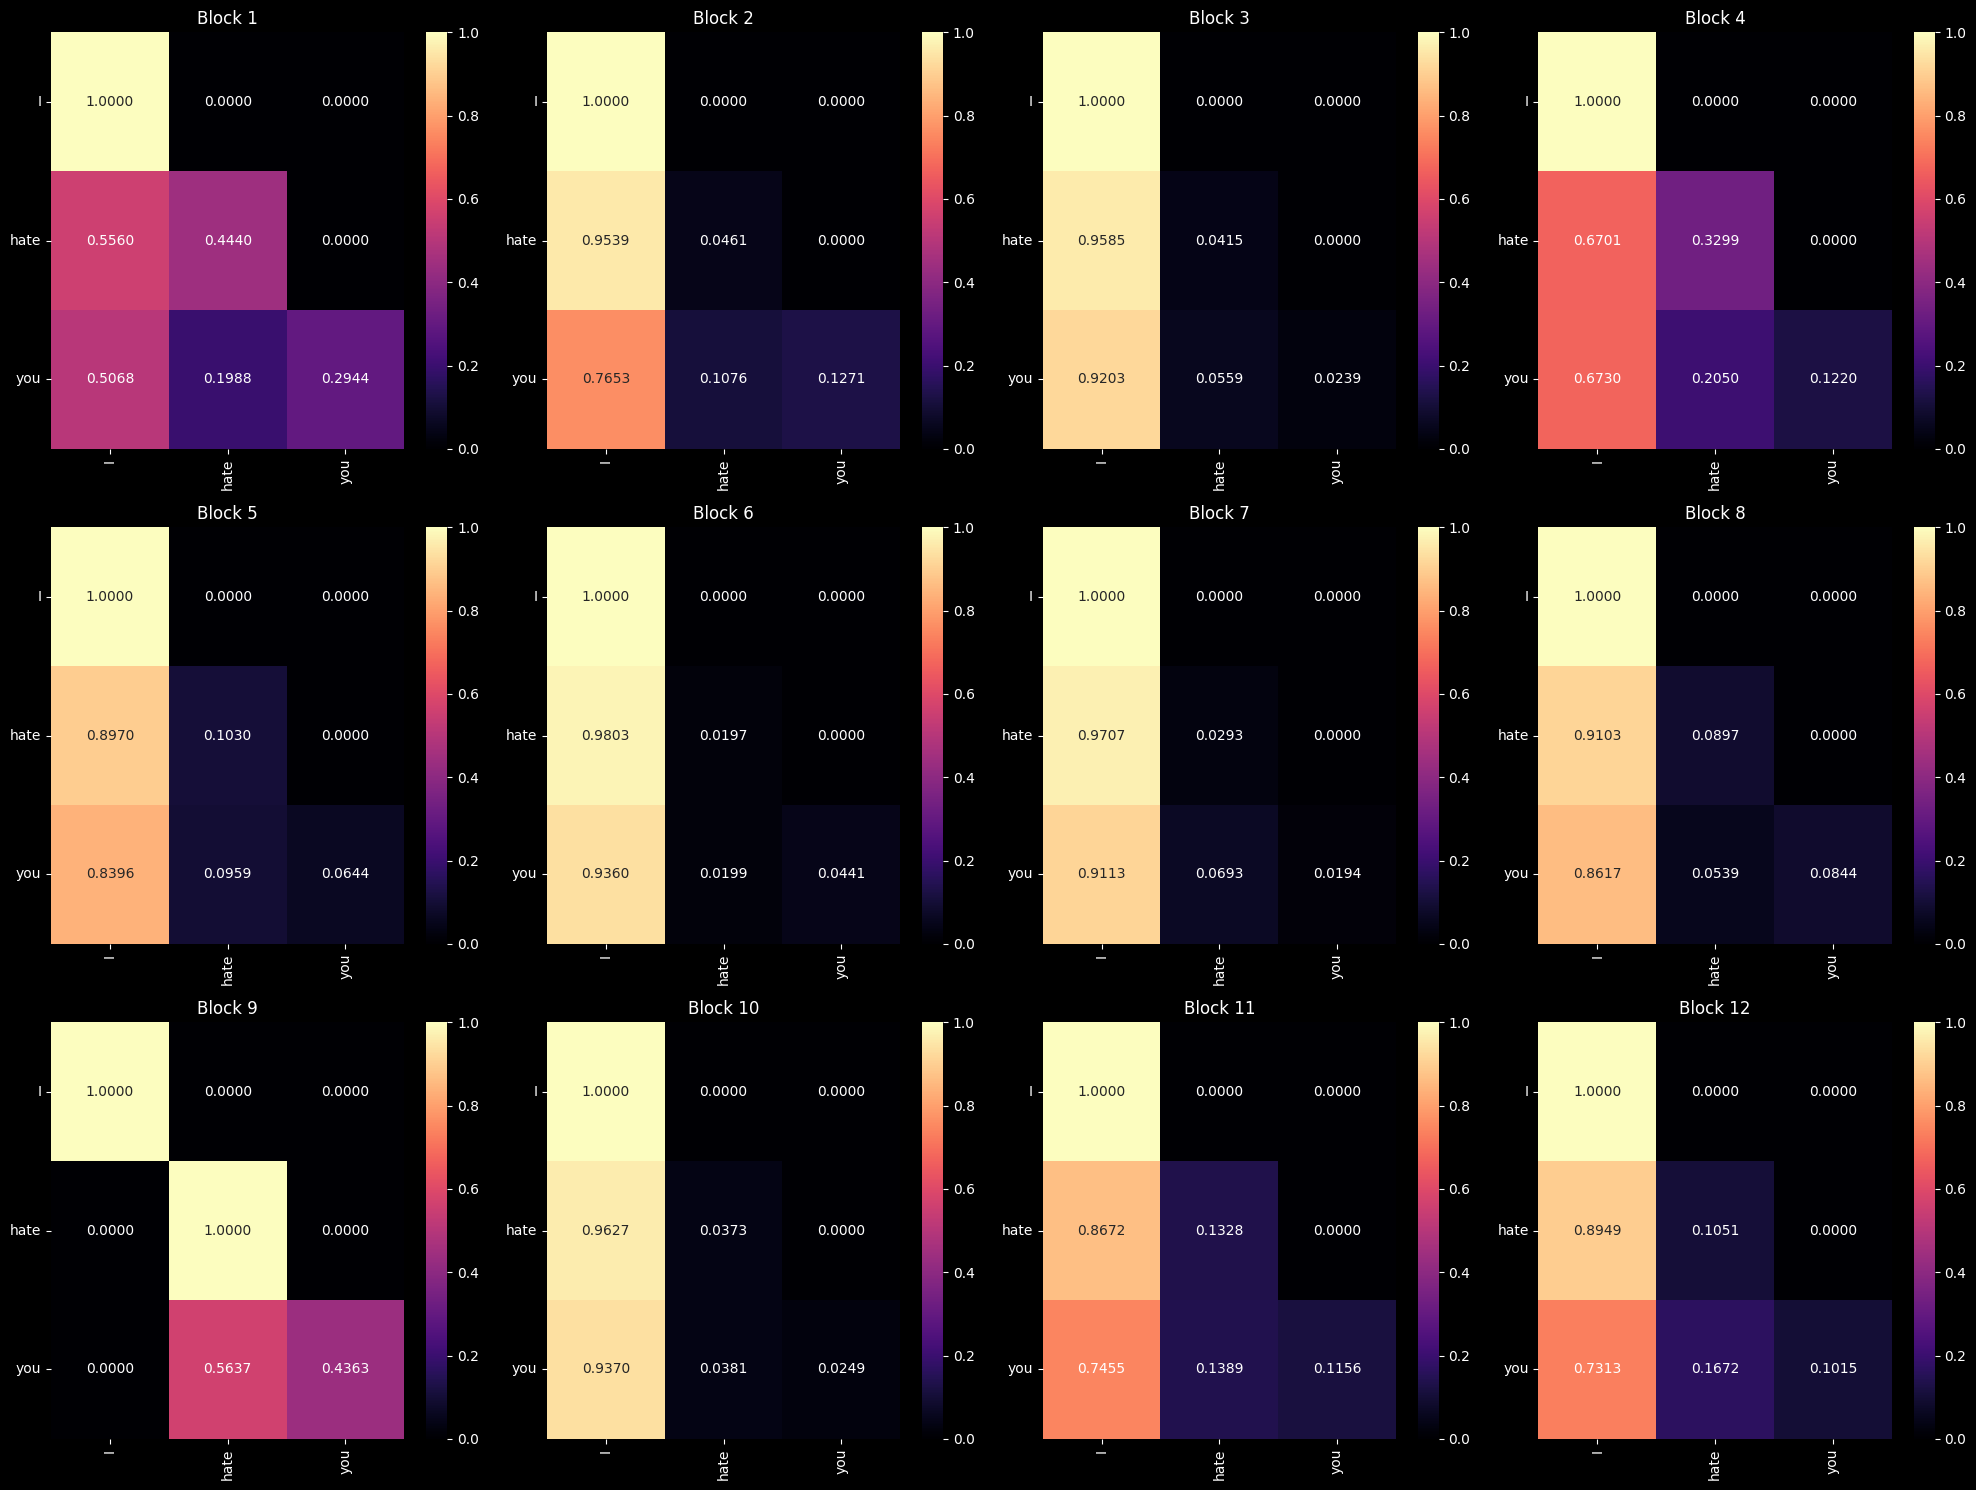

In [172]:
tv.display(negative_prompt, layer=0)

## Viewing by third dimension or Layer (?)

#### Block: <span style="color:cyan;">0</span> (first block) 

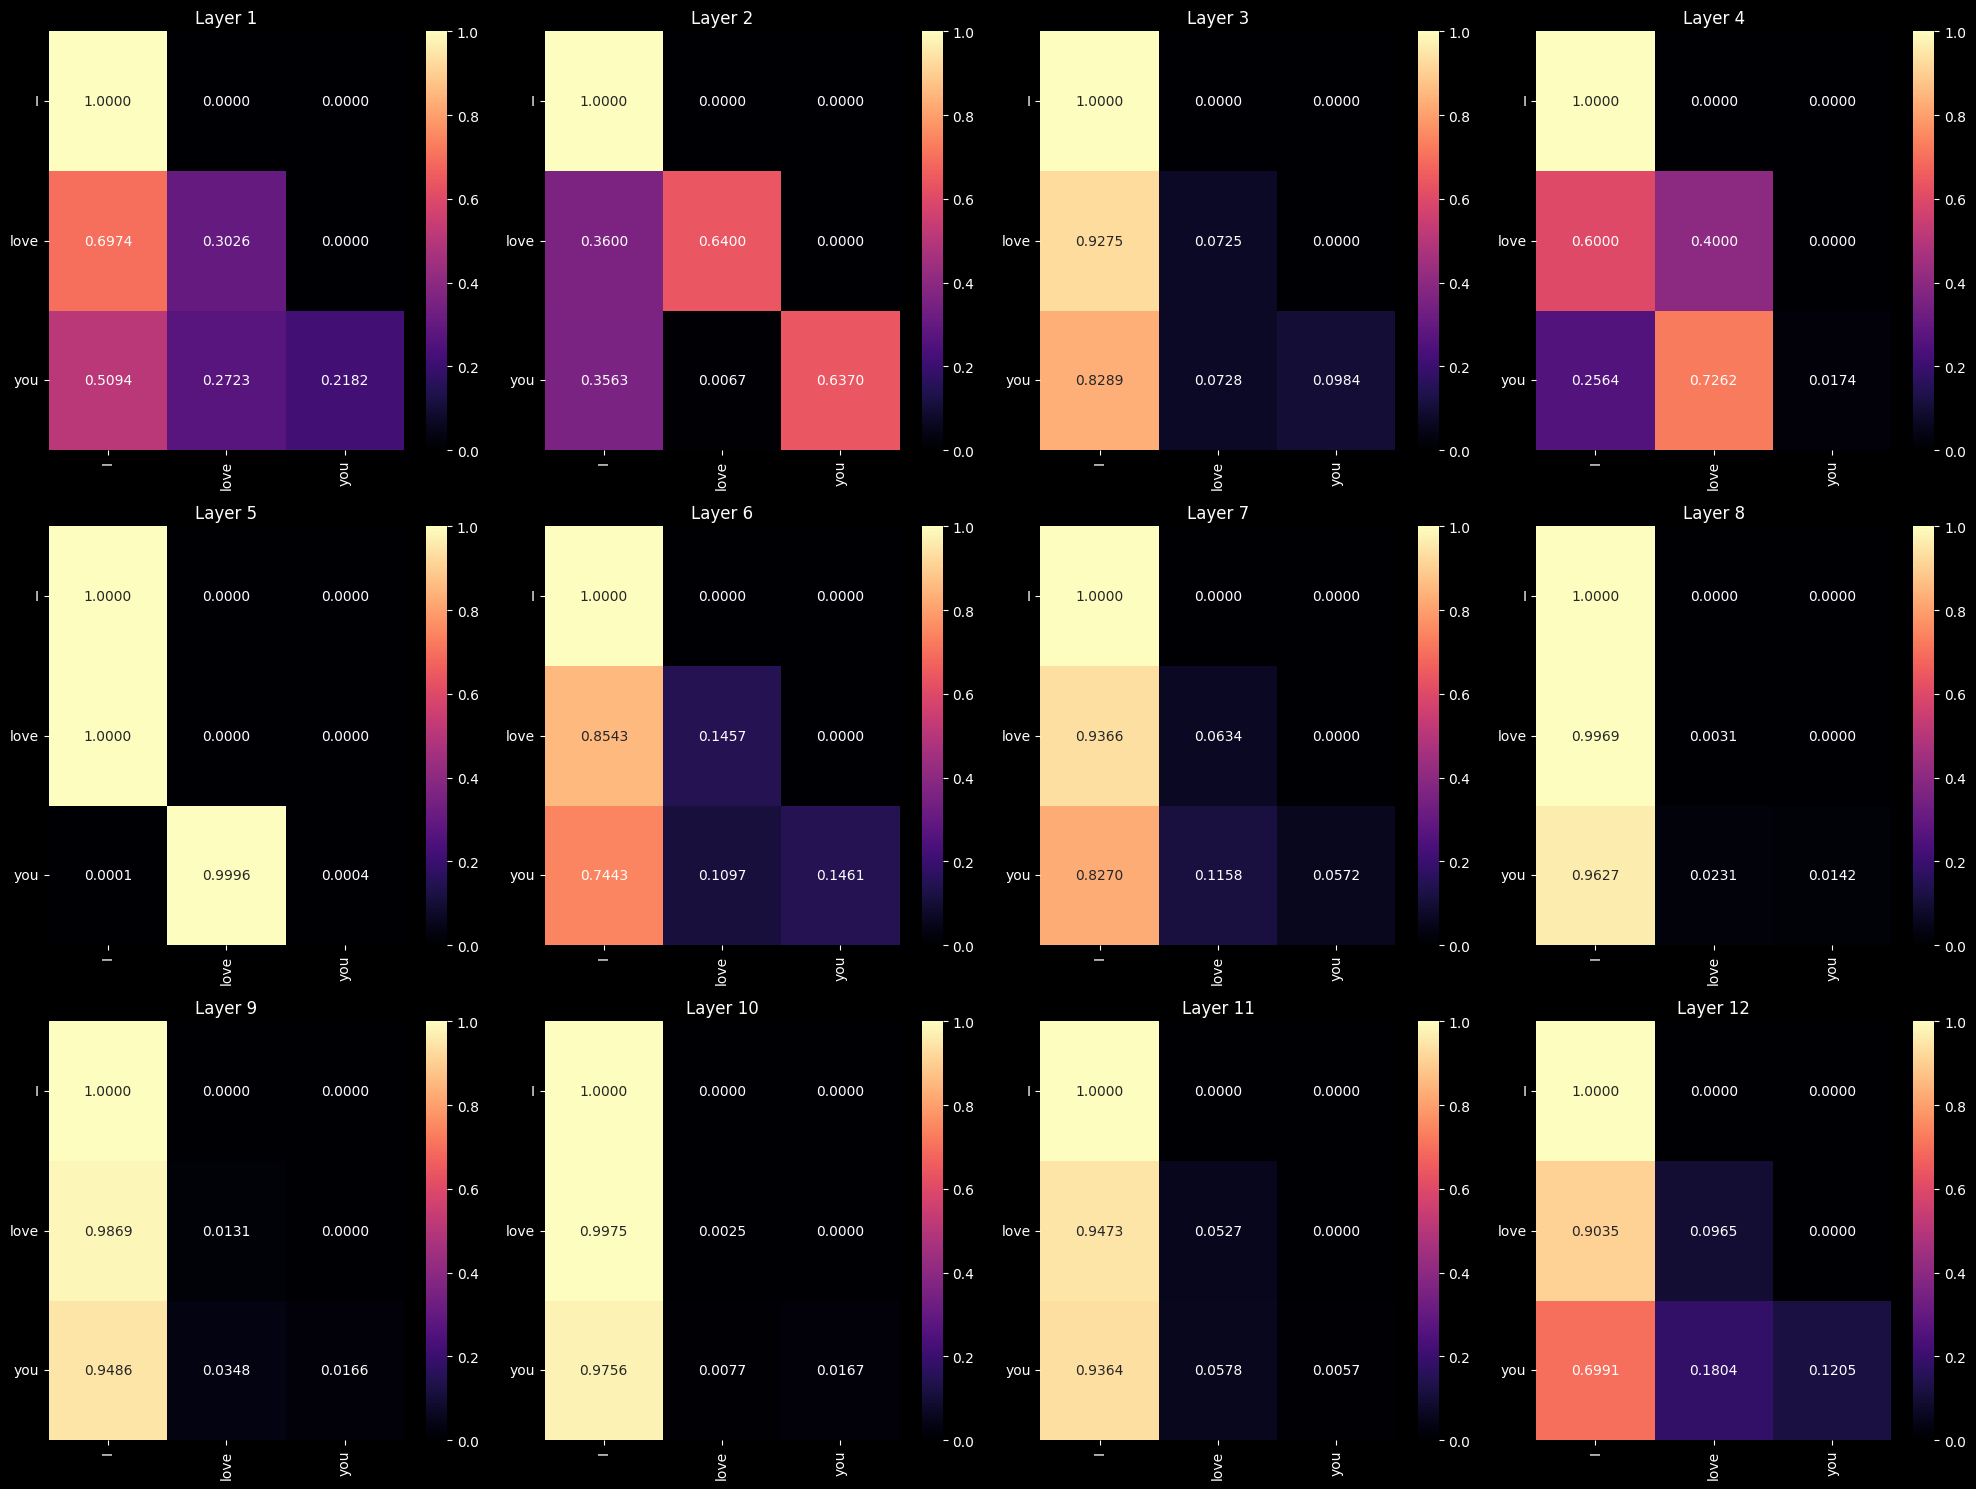

In [123]:
tv.display(positive_prompt, view_by="layer", block=0)

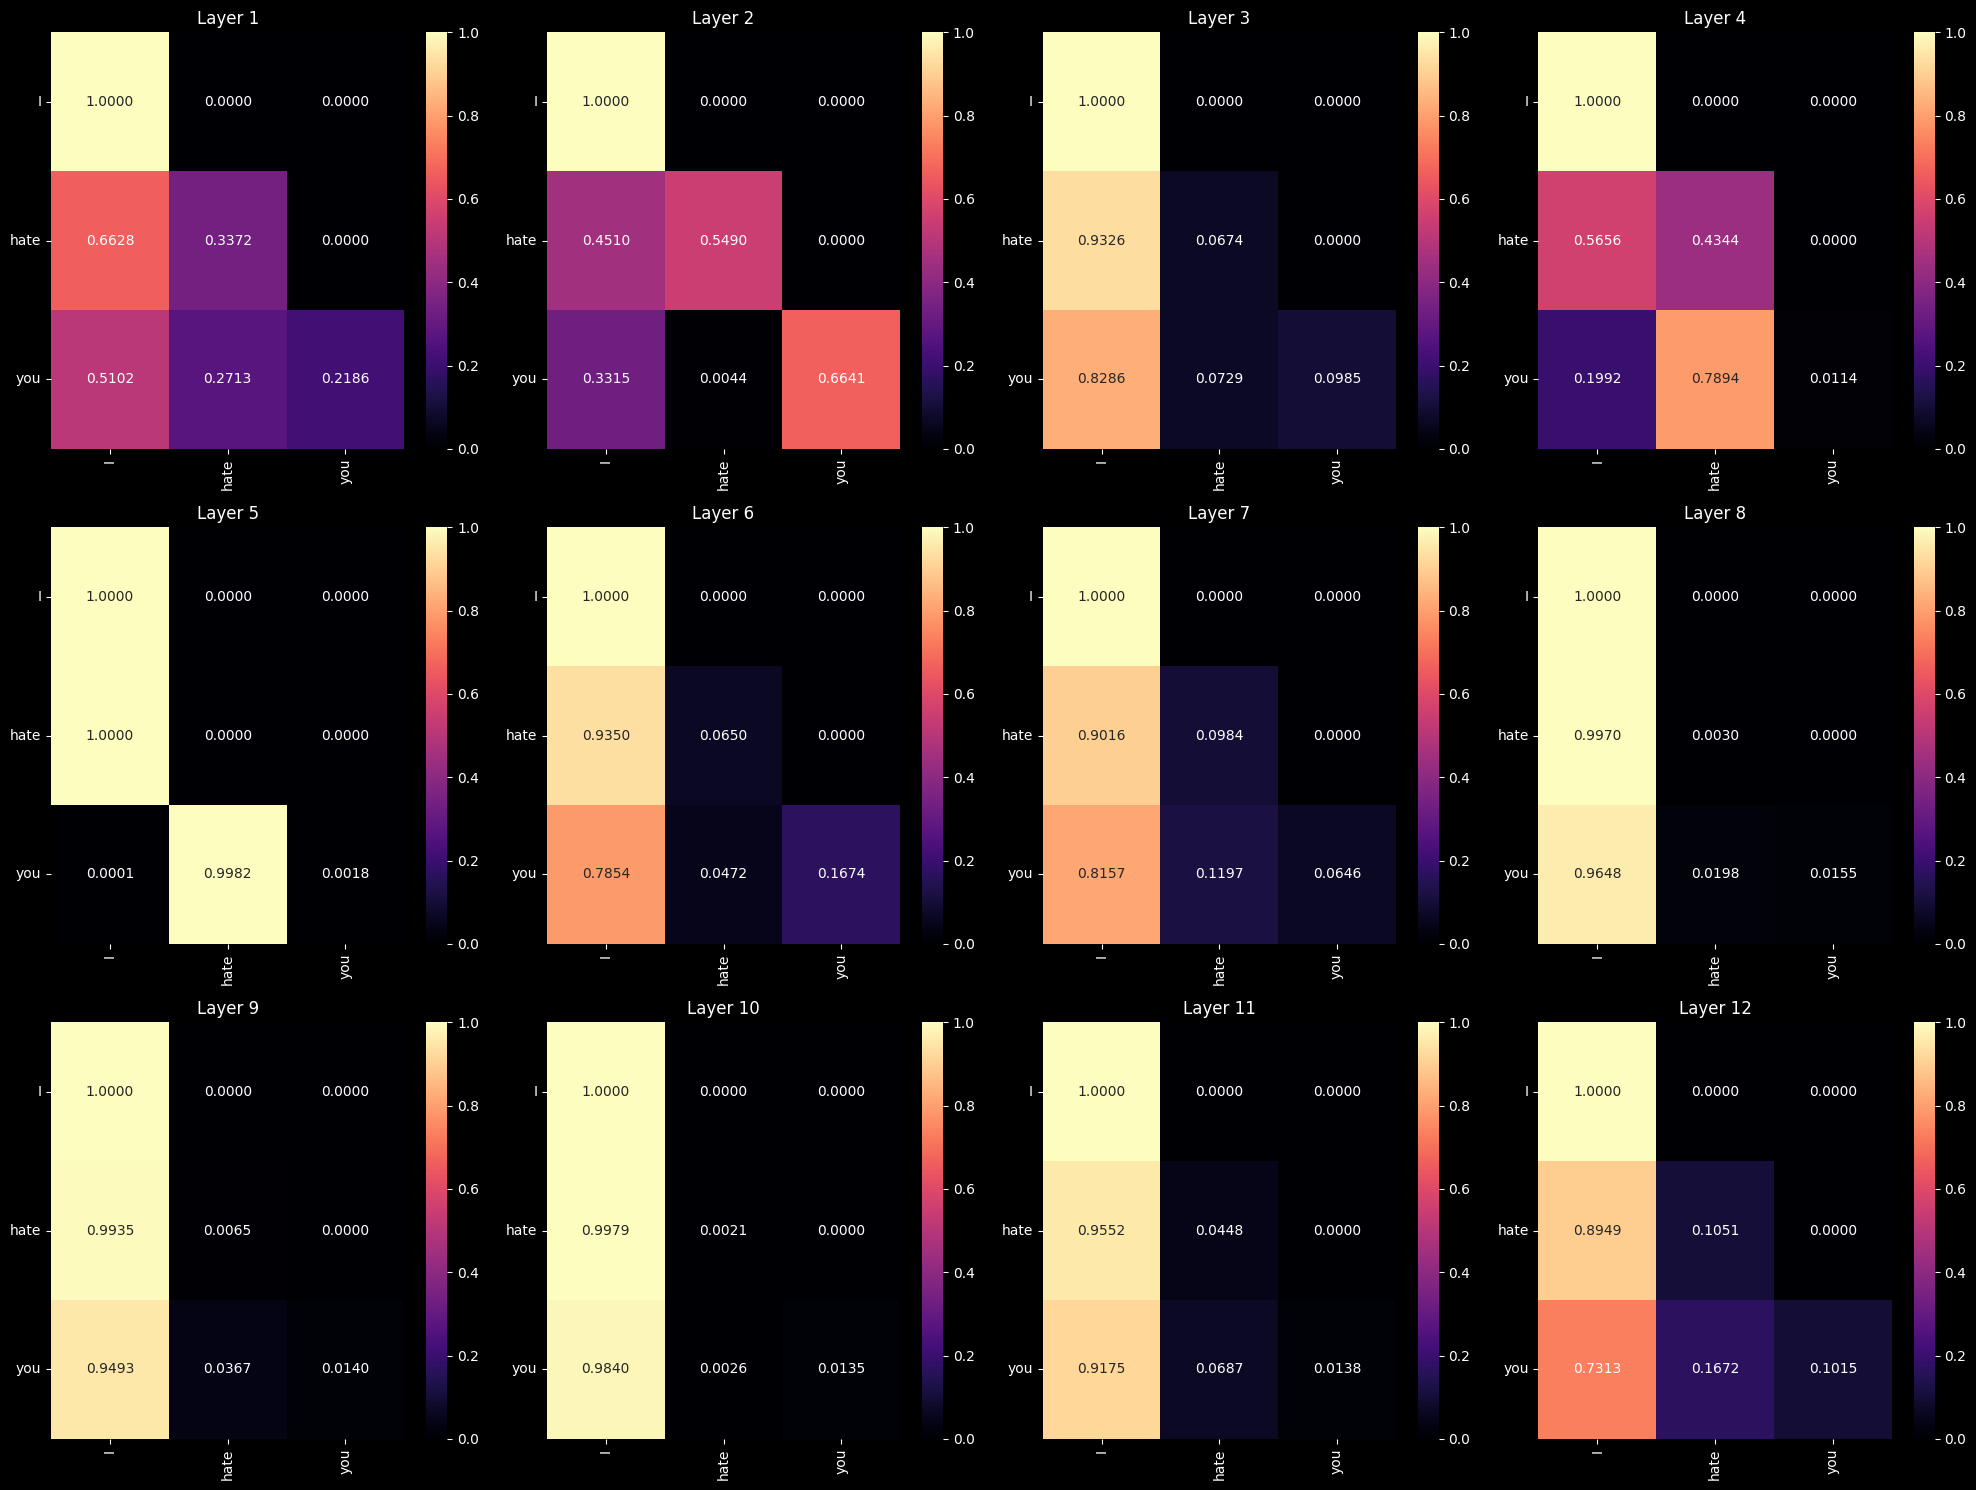

In [124]:
tv.display(negative_prompt, view_by="layer", block=0)

#### Block: <span style="color:cyan;">12</span> (last block) 

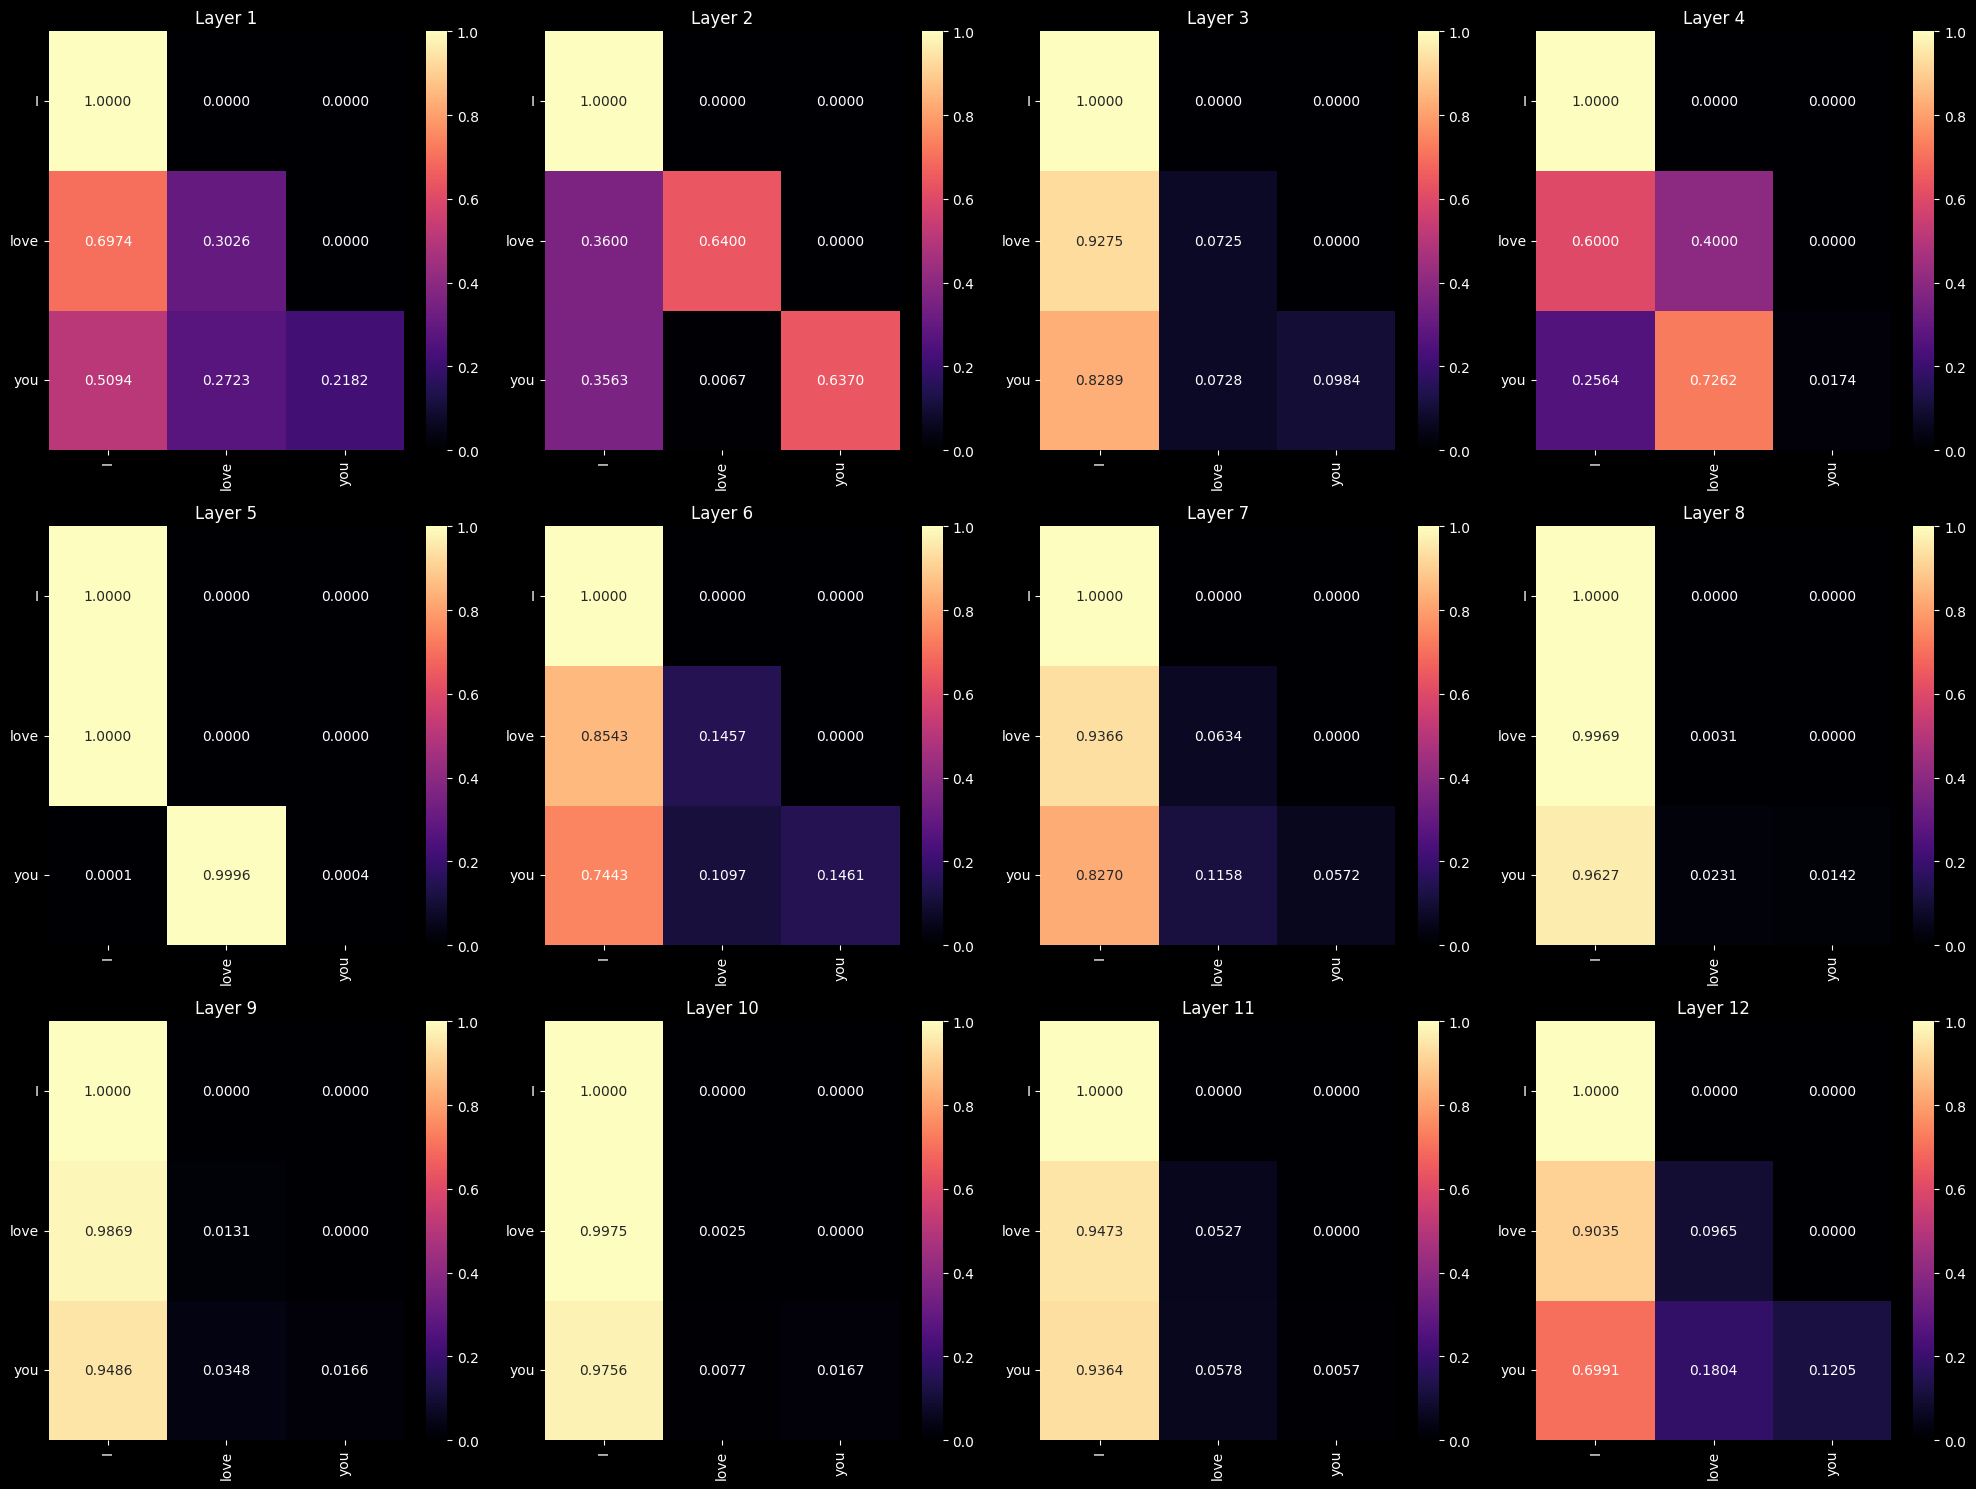

In [126]:
tv.display(positive_prompt, view_by="layer", block=-1)

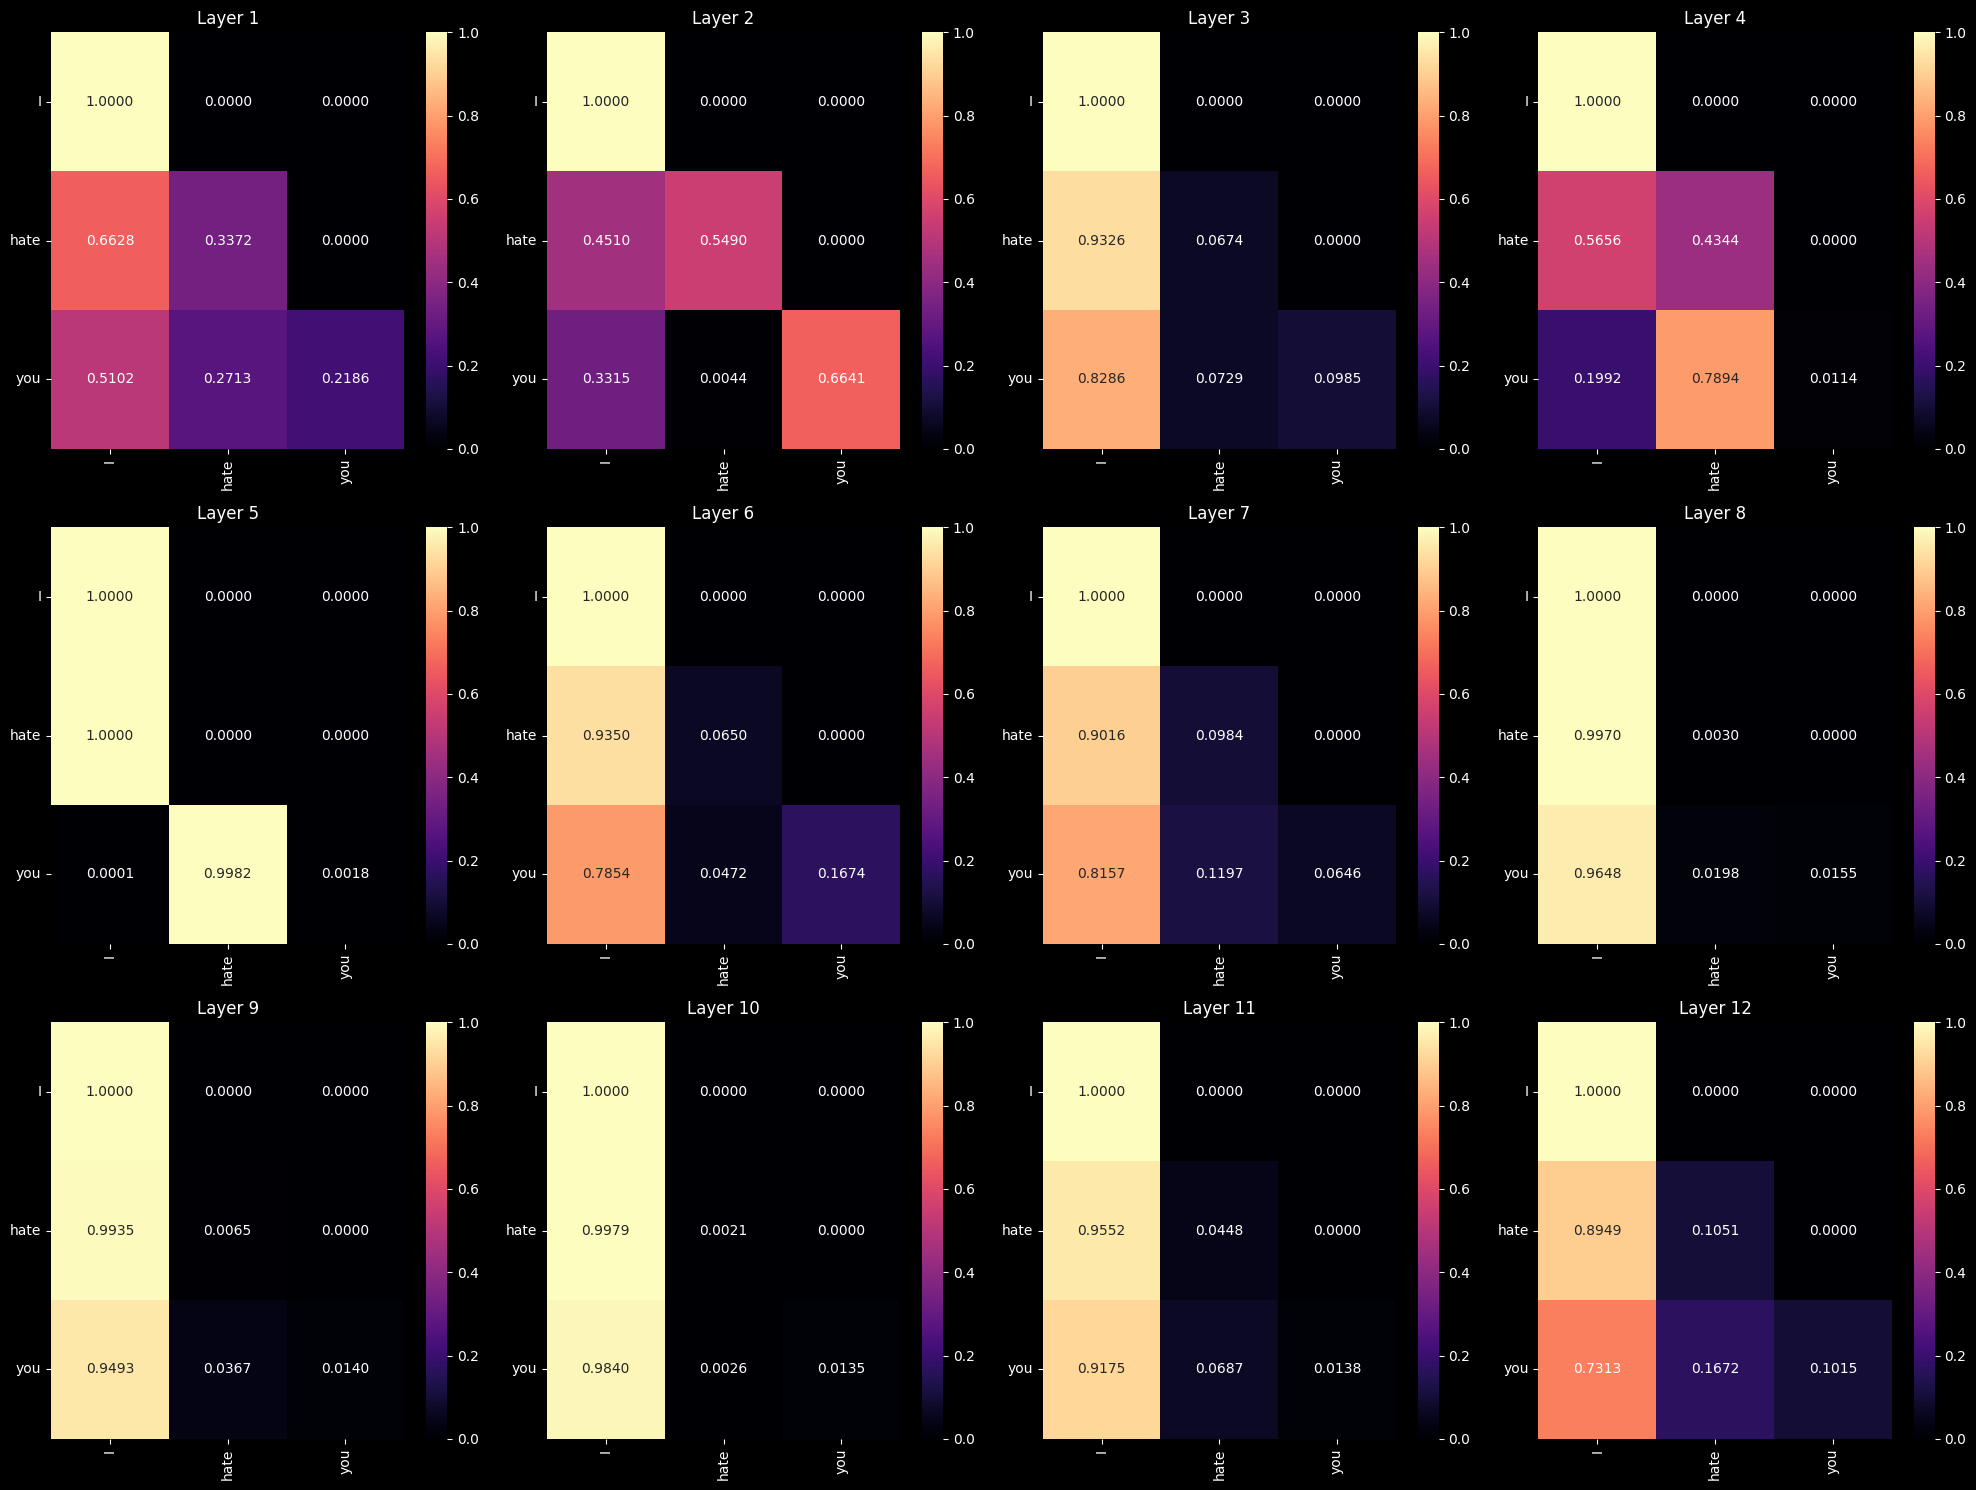

In [125]:
tv.display(negative_prompt, view_by="layer", block=-1)

## Viewing by Layer and averaging the last 4 components

In [173]:
tv.last_attention(start=4, use_last_cache=True)

array([[1.        , 0.        , 0.        ],
       [0.8104    , 0.1896    , 0.        ],
       [0.745316  , 0.14335513, 0.11132886]], dtype=float32)